# Volatility Forecasting - GARCH Test

In [ ]:
import sys
import os
sys.path.append(os.path.abspath("../src"))  # Adjust if notebook is deeper
import yfinance as yf
import numpy as np
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt


In [ ]:
from data_loader import fetch_price_data, compute_log_returns

ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-12-31'

df = fetch_price_data(ticker, start_date, end_date)

# Use 'Adj Close' if available, else fallback to 'Close'
price_col = ('Adj Close', ticker) if ('Adj Close', ticker) in df.columns else ('Close', ticker)
log_returns = compute_log_returns(df[price_col])

print(df.head())  # correct print statement



[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.716072  72.776598  71.466812  71.721019  135480400
2020-01-03  72.009125  72.771752  71.783969  71.941336  146322800
2020-01-06  72.582924  72.621661  70.876090  71.127881  118387200
2020-01-07  72.241547  72.849224  72.021231  72.592594  108872000
2020-01-08  73.403648  73.706279  71.943759  71.943759  132079200


In [ ]:
# garch_model.py
from arch import arch_model

def fit_garch_model(log_returns):
    model = arch_model(log_returns, vol='Garch', p=1, q=1)
    return model.fit(disp='off')

def forecast_volatility(garch_result, horizon=5):
    forecast = garch_result.forecast(horizon=horizon)
    return forecast.variance.iloc[-1]**0.5


In [ ]:
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-12-31'

data = yf.download(ticker, start=start_date, end=end_date)

# Step 3: Compute log returns
adj_close = data[('Close', ticker)]  # Adjust this if using MultiIndex
data['Log Return'] = np.log(adj_close / adj_close.shift(1))
data = data.dropna()

# Step 4: Fit GARCH(1,1) model
model = arch_model(data['Log Return'], vol='Garch', p=1, q=1)
garch_result = model.fit(disp='off')

# Step 5: Forecast next 5-day volatility
vol_forecast = garch_result.forecast(horizon=5)
np_vol = np.sqrt(vol_forecast.variance.values[-1])

# Display summary and forecast
print(garch_result.summary())
print("📉 5-day forecasted volatility:")
print(np_vol)



[*********************100%***********************]  1 of 1 completed

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Log Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2577.48
Distribution:                  Normal   AIC:                          -5146.97
Method:            Maximum Likelihood   BIC:                          -5127.32
                                        No. Observations:                 1005
Date:                Thu, Apr 17 2025   Df Residuals:                     1004
Time:                        11:35:07   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.6892e-03  5.677e-04      2.976  2.924e-03 [5.


/Users/vansh/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004463. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


/Users/vansh/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


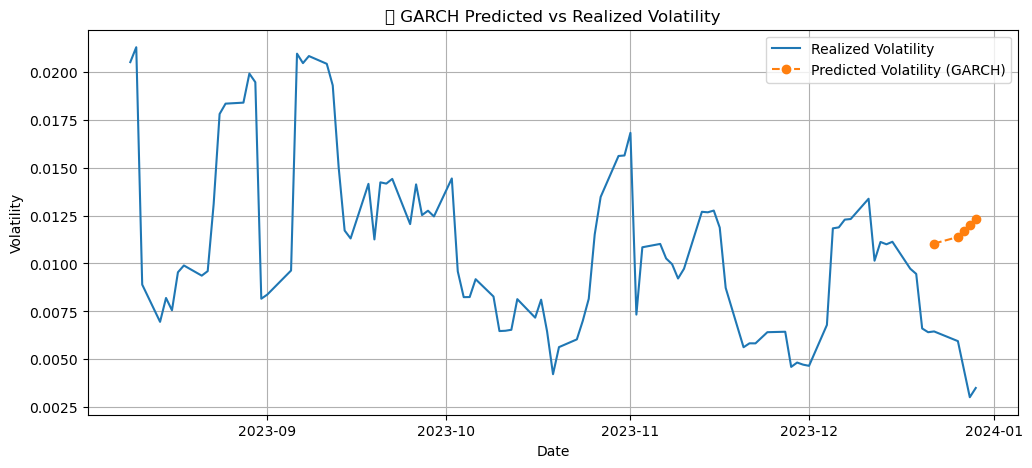

In [ ]:
# Step 4: Validate predicted volatility against realized volatility

# Calculate realized volatility (rolling std of log returns)
realized_vol = log_returns.rolling(window=5).std()

# Plot predicted vs realized volatility
plt.figure(figsize=(12, 5))
plt.plot(realized_vol.index[-100:], realized_vol[-100:], label='Realized Volatility')
plt.plot(realized_vol.index[-5:], np_vol, label='Predicted Volatility (GARCH)', marker='o', linestyle='--')
plt.title("📊 GARCH Predicted vs Realized Volatility")
plt.ylabel("Volatility")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()


/Users/vansh/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004463. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/vansh/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004463. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/vansh/anaconda3/lib/python3.11/site-packages/arch/u

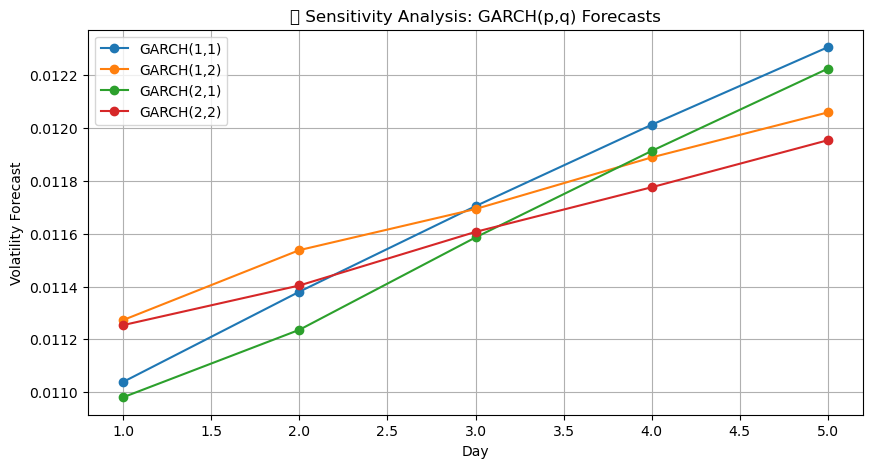

In [ ]:
from arch import arch_model

# Try combinations of p and q
param_grid = [(1,1), (1,2), (2,1), (2,2)]
forecasts = {}

for p, q in param_grid:
    model = arch_model(log_returns, vol='Garch', p=p, q=q)
    result = model.fit(disp="off")
    forecast = result.forecast(horizon=5)
    forecasts[f"GARCH({p},{q})"] = np.sqrt(forecast.variance.values[-1])

# Plot comparison
plt.figure(figsize=(10, 5))
for label, values in forecasts.items():
    plt.plot(range(1, 6), values, label=label, marker='o')
    
plt.title("🔬 Sensitivity Analysis: GARCH(p,q) Forecasts")
plt.xlabel("Day")
plt.ylabel("Volatility Forecast")
plt.legend()
plt.grid(True)
plt.show()
